# Comparison of the Serre-Green-Naghdi and Whitham-Green-Naghdi models

*We provide a comparative analysis of the Serre-Green-Naghdi model (SGN) with a fully dispersive counterpart, named Whitham-Green-Naghdi (WGN). A more thorough analysis, reproducing the figures in [V. Duchêne and C. Klein](http://dx.doi.org/10.3934/dcdsb.2021300), is available [/examples/StudyWhithamGreenNaghdi.jl](../examples/StudyWhithamGreenNaghdi.jl).*

Import package

In [1]:
Pkg.activate("..")
using Plots,FFTW,WaterWaves1D

 Activating environment at `~/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/Project.toml`


## Solitary wave comparison

Generate solitary waves

In [2]:
param = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    μ = 1,     # shallow-water dimensionless parameter
    ϵ = 1,     # nonlinearity dimensionless parameter
    c = 1.05,  # velocity of the solitary wave
    # Numerical parameters
    N = 2^10,  # number of collocation points
    L = 150    # half-length of the numerical tank (-L,L)
                );
# Compute the WGN solitary wave with velocity c (type `?SolitaryWaveWhithamGreenNaghdi` for more details)
(ηWGN,uWGN,vWGN,mesh) = SolitaryWaveWhithamGreenNaghdi(param,verbose=false);
# Compute the SGN solitary wave with velocity c (there is an exact formula)
(ηSGN,uSGN,vSGN) = SolitaryWaveSerreGreenNaghdi(param);

┌ Info: Computing the WGN solitary wave with velocity c=1.05
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/initialdata/SolitaryWaveWhithamGreenNaghdi.jl:52
┌ Info: Using the exact formula for the SGN solitary wave as initial guess
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/initialdata/SolitaryWaveWhithamGreenNaghdi.jl:63
┌ Info: Converged : relative error 3.55595133056873e-16 in 3 steps
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/initialdata/SolitaryWaveWhithamGreenNaghdi.jl:241


The difference beween the Serre-Green-Naghdi (SGN) and Whitham-Green-Naghdi (WGN) solitary waves is more easily seen on Fourier coefficients

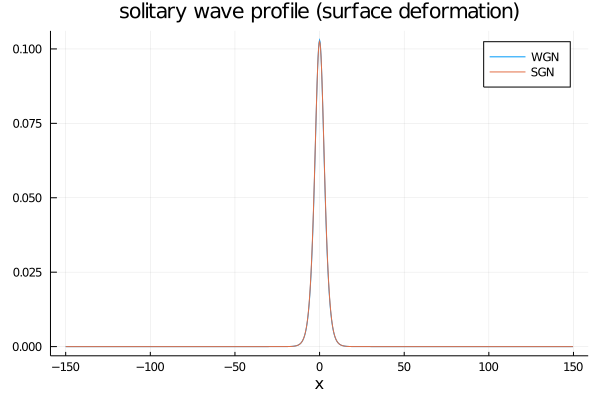

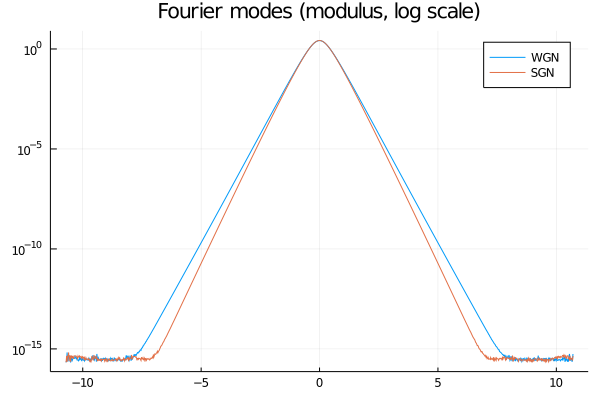

In [3]:
plt=plot(mesh.x, [ηWGN ηSGN];
    title="solitary wave profile (surface deformation)",xlabel = "x",label=["WGN" "SGN"])
display(plt)
plt=plot(fftshift(mesh.k),
    [abs.(fftshift(fft(ηWGN))).+eps() abs.(fftshift(fft(ηSGN))).+eps()];
    title="Fourier modes (modulus, log scale)",label=["WGN" "SGN"],yscale=:log10)
display(plt)


Validate the solitary wave through time integration

In [4]:
T=2*param.L/param.c # final time of computation
dt=T/10^3   # timestep
init = Init(mesh,ηWGN,vWGN);           # use solitary wave as initial data
model = WhithamGreenNaghdi(param)      # define the model 
pb = Problem(                          # set up the initial-value problem to be solved
    model,
    init, 
    merge(param,(T=T,dt=dt)), 
    solver=RK4(model)   ) 
solve!(pb)                             # solve the initial-value problem

┌ Info: model Whitham-Green-Naghdi
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:54
┌ Info: no dealiasing
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:86
┌ Info: elliptic problem solved with GMRES method
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:92
┌ Info: 
│ Build the initial-value problem for model Whitham-Green-Naghdi
│ with parameters
│ (μ = 1, ϵ = 1, c = 1.05, N = 1024, L = 150, T = 285.7142857142857, dt = 0.2857142857142857)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/problem.jl:46
┌ Info: 
│ Now solving the initial-value problem for model Whitham-Green-Naghdi
│ with parameters
│ (μ = 1, ϵ = 1, c = 1.05, N = 1024, L = 150, T = 285.7142857142857, dt = 0.2857142857142857)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/Water

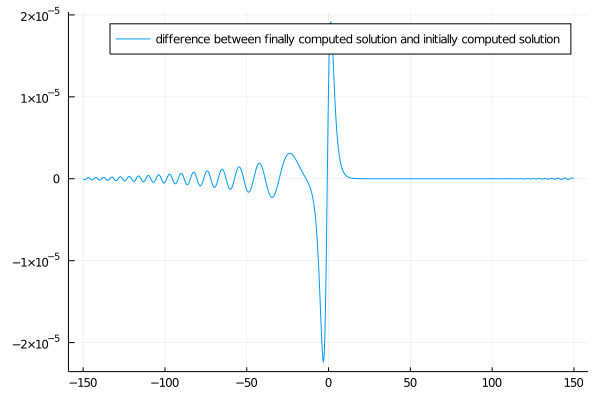

In [5]:
ηfin,=solution(pb)
plot(mesh.x,ηWGN-ηfin,
    label="difference between finally computed solution and initially computed solution")

The main difference is due to the time integration (as seen when diminishing the timestep).

## SGN and WGN solitary waves as initial data for the water waves system

Solve the initial-value problems

In [6]:
T=2*param.L/param.c # final time of computation
dt=T/10^3   # timestep
initWGN = Init(mesh,ηWGN,vWGN);       # WGN solitary wave as initial data
initSGN = Init(mesh,ηSGN,vSGN);       # SGN solitary wave as initial data
model=WaterWaves(param, verbose=true) # The water waves system
pbSGN = Problem(                         # initial-value problem with SGN initial data
    model,
    initSGN, 
    merge(param,(T=T,dt=dt)), 
    solver=RK4(model)   ) 
pbWGN = Problem(                         # initial-value problem with WGN initial data
    model,
    initWGN, 
    merge(param,(T=T,dt=dt)), 
    solver=RK4(model)   ) 
solve!([pbSGN pbWGN])                             # solve the initial-value problems

┌ Info: no dealiasing
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WaterWaves.jl:82
┌ Info: 
│ Build the initial-value problem for model water waves
│ with parameters
│ (μ = 1, ϵ = 1, c = 1.05, N = 1024, L = 150, T = 285.7142857142857, dt = 0.2857142857142857)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/problem.jl:46
┌ Info: Relative error 1.018365322130506 at step 1
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WaterWaves.jl:206
┌ Info: Relative error 0.03530939210398393 at step 2
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WaterWaves.jl:206
┌ Info: Relative error 0.0007722051074456983 at step 3
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WaterWaves.jl:206
┌ Info: Relative error 8.81022050934008e-6 at step 4
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWave

┌ Info: 
│ Done solving the model water waves
│ with parameters
│ (μ = 1, ϵ = 1, c = 1.05, N = 1024, L = 150, T = 285.7142857142857, dt = 0.2857142857142857)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/problem.jl:175


Plot solutions

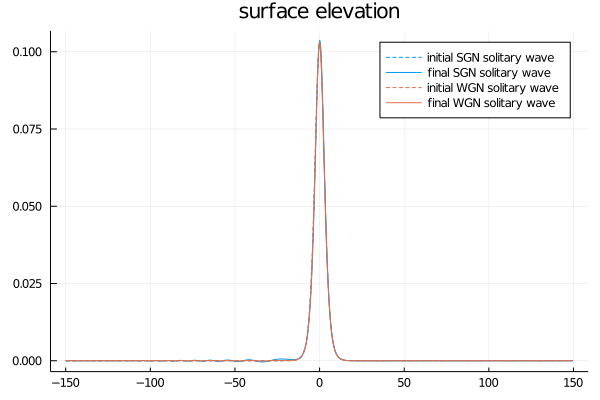

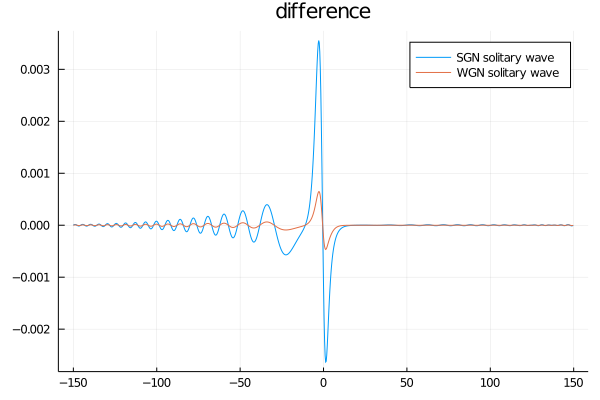

In [7]:
ηSGNfin,vSGNfin,xSGNfin=solution(pbSGN)
ηWGNfin,vWGNfin,xWGNfin=solution(pbWGN)
ηSGNinit,vSGNinit,xSGNinit=solution(pbSGN,t=0)
ηWGNinit,vWGNinit,xWGNinit=solution(pbWGN,t=0)

plt=plot([xSGNinit xSGNfin xWGNinit xWGNfin],[ηSGNinit ηSGNfin ηWGNinit ηWGNfin],
    color=[:1 :1 :2 :2],linestyle=[:dash :solid :dash :solid],
    label=["initial SGN solitary wave" "final SGN solitary wave" "initial WGN solitary wave" "final WGN solitary wave"],
    title="surface elevation")
display(plt)
plt=plot(xSGNfin,[ηSGNinit-ηSGNfin ηWGNinit-ηWGNfin],
    label=["SGN solitary wave" "WGN solitary wave"],
    title="difference")
display(plt)

The difference (between the solution and the translated initial data) reduces as the velocity approaches 1, and the deifference for the WGN solitary wave is one order of magnitude smaller than for the SGN solitary wave. 

The last plot is slightly inexact: one should interpolate solutions on matching collocation points. 

## Soliton resolution

Prepare the initial-value problem

In [8]:
param = ( 
    # Physical parameters. Variables are non-dimensionalized as in Lannes, The water waves problem, isbn:978-0-8218-9470-5
    μ = 0.01,   # shallow-water dimensionless parameter
    ϵ = 0.5,    # nonlinearity dimensionless parameter
    # Numerical parameters
    N = 2^10,   # number of collocation points
    L = 10,     # half-length of the numerical tank (-L,L)
    T = 10,     # final time of integration
    dt=0.01,   # timestep
            );
# Initial data (unidirectional at first order)
η(x) = exp.(-(x .+ 5).^2);       # surface elevation
v(x) = (2*sqrt.(1 .+ param.ϵ*η(x)) .-2)/param.ϵ;   # velocity (derivative of the trace of the velocity potential at the surface)

Solve the initial-value problem

In [9]:
init = Init(η,v);       # Set initial data
mWW  = WaterWaves(param,dealias=1) # define the water waves system
mSGN = SerreGreenNaghdi(param,dealias=1) # define the Green-Naghdi system
mWGN = WhithamGreenNaghdi(param,dealias=1) # define the (full dispersion) Whitham-Green-Naghdi system

pbWW = Problem(                         # initial-value problem for the water waves system
    mWW,
    init, 
    param, 
    solver=RK4(mWW)   ) 
pbSGN = Problem(                         # initial-value problem for the Green-Naghdi system
    mSGN,
    init, 
    param, 
    solver=RK4(mSGN)   ) 
pbWGN = Problem(                         # initial-value problem for the Whitham-Green-Naghdi system
    mWGN,
    init, 
    param, 
    solver=RK4(mSGN)   ) 

solve!(pbWW); solve!(pbSGN); solve!(pbWGN);         # solve the initial-value problems      

┌ Info: dealiasing : spectral scheme for power 2 nonlinearity 
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WaterWaves.jl:85
┌ Info: model Serre-Green-Naghdi
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:54
┌ Info: dealiasing : spectral scheme for power 2 nonlinearity 
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:89
┌ Info: elliptic problem solved with GMRES method
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:92
┌ Info: model Whitham-Green-Naghdi
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:54
┌ Info: dealiasing : spectral scheme for power 2 nonlinearity 
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/models/WhithamGreenNaghdi.jl:89
┌ Inf

┌ Info: 
│ Now solving the initial-value problem for model Serre-Green-Naghdi
│ with parameters
│ (μ = 0.01, ϵ = 0.5, N = 1024, L = 10, T = 10, dt = 0.01)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/problem.jl:91
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


┌ Info: 
│ Now solving the initial-value problem for model Whitham-Green-Naghdi
│ with parameters
│ (μ = 0.01, ϵ = 0.5, N = 1024, L = 10, T = 10, dt = 0.01)
└ @ WaterWaves1D /Users/vduchene/Desktop/Julia/WaterWavesModels/WaterWaves1D.jl/src/problem.jl:91
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


Plot solutions

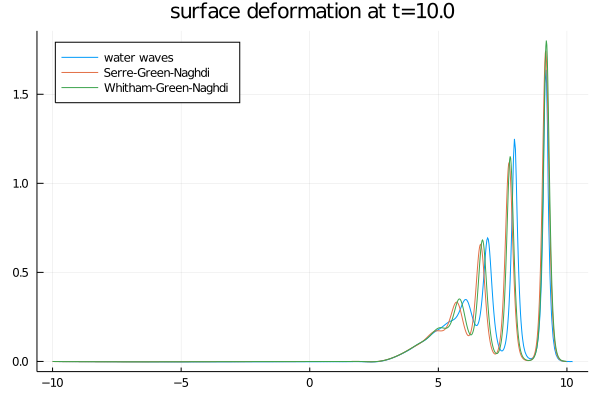

In [10]:
plt=plot_solution([pbWW pbSGN pbWGN],t=10,fourier=false)
plot!(plt,legend=:topleft);
display(plt)
# Uncomment the following line to plot differences
#plt=plot_difference([(pbWW,pbSGN) (pbWW,pbWGN)],fourier=false,label=["ww-SGN" "ww-WGN"])
# Uncomment the following line to generate animation
#anim=create_animation([pbWW pbSGN pbWGN],fourier=false,ylims=(-0.1,2));gif(anim)

The Whitham-Green-Naghdi model is not significantly better than the original Green-Naghdi model at predicting the large-time behavior (here, solitary wave resolution) of water waves as strong gradients are generated. The situation is better when the nonlinearity parameter, ϵ, is set to 0.25 (say).